In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip uninstall scikit-learn

In [3]:
import sklearn
sklearn.__version__

'1.6.1'

In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, average_precision_score
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,TargetEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample

In [6]:
# pip install category_encoders

In [7]:
df_accident = pd.read_csv("../DataDecoding/Final.csv")

In [8]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100927 entries, 0 to 100926
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              100927 non-null  object 
 1   Accident Date               100927 non-null  object 
 2   Day_of_Week                 100927 non-null  object 
 3   Junction_Control            100927 non-null  object 
 4   Junction_Detail             100927 non-null  object 
 5   Accident_Severity           100927 non-null  object 
 6   Latitude                    100927 non-null  float64
 7   Light_Conditions            100927 non-null  object 
 8   Local_Authority_(District)  100927 non-null  int64  
 9   Carriageway_Hazards         100927 non-null  object 
 10  Longitude                   100927 non-null  float64
 11  Number_of_Casualties        100927 non-null  int64  
 12  Number_of_Vehicles          100927 non-null  int64  
 13  Police_Force  

In [9]:
df_accident.isnull().sum()

Accident_Index                0
Accident Date                 0
Day_of_Week                   0
Junction_Control              0
Junction_Detail               0
Accident_Severity             0
Latitude                      0
Light_Conditions              0
Local_Authority_(District)    0
Carriageway_Hazards           0
Longitude                     0
Number_of_Casualties          0
Number_of_Vehicles            0
Police_Force                  0
Road_Surface_Conditions       0
Road_Type                     0
Speed_limit                   0
Time                          0
Urban_or_Rural_Area           0
Weather_Conditions            0
dtype: int64

In [10]:
df_accident.dropna(inplace=True)

##### Created by Meet Gandhi | Method created to alter the columns value that were necessary and apply custom sampling to the data.

In [11]:
def alter_columns(X):
    X = X.copy()
    
    drop_columns = ['Latitude','Longitude','Accident_Index','Time','Local_Authority_(District)','Accident Date']
    X.drop(columns=drop_columns,inplace=True)
    
    X['Junction_Control'] = X['Junction_Control'].replace('Auto traffic sigl','Auto traffic signal')
#   df_accident = df_accident[df_accident['Junction_Control']!='Data missing or out of range']
    
    X['Accident_Severity'] = X['Accident_Severity'].replace('Fetal','Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Fatal','Serious/Fatal')
    X['Accident_Severity'] = X['Accident_Severity'].replace('Serious','Serious/Fatal')
    
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Wet or damp','Wet')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Frost or ice','Frost')
    X['Road_Surface_Conditions'] = X['Road_Surface_Conditions'].replace('Flood over 3cm. deep','Flood')
    
#   X.drop(columns = ['Police_Force'],inplace=True)
    
    X['Accident_Severity'] = X['Accident_Severity'].map({
        'Slight': 0,
        'Serious/Fatal' : 1
    })
      
    return X

In [12]:
def val_counts(X,column_name):
    print(X[column_name].value_counts())

val_counts(df_accident,'Accident_Severity')

Slight     75858
Serious    23567
Fatal       1502
Name: Accident_Severity, dtype: int64


##### Created by Meet Gandhi | Class creation for the Feature Engineering that need to be done for the X_test and y_train.

In [13]:
class Feature_Engineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X = X.copy()

        # X.drop(columns=drop_columns,inplace=True)

        # Creating new column from Urban_or_Rural Columns from the data.
        X['is_urban'] = X['Urban_or_Rural_Area'] == 'Urban'
        X.drop(columns=['Urban_or_Rural_Area'],inplace=True)
        
        # Creating new column from CarrieHazards from the data.
        X['is_Carry_hazards'] = X['Carriageway_Hazards'] != 'None'
        X.drop(columns=['Carriageway_Hazards'],inplace=True)
        
        # Creating new columns from the weather_conditions.
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*\+\s*high winds','',regex=True)
        X['Weather_Condition'] = X['Weather_Conditions'].str.replace(r'\s*no high winds','',regex=True)
        
        X['Wind_Condition'] = X['Weather_Conditions'].apply(
        lambda x: 'No High Winds' if 'no high winds' in x.lower()
            else ('High Winds' if 'high winds' in x.lower() else 'Other')
        )
        
        X.drop(columns = ['Weather_Conditions'],inplace=True)

        # Creating new Feature from light_conditions
        X['Light_Condition'] = X['Light_Conditions']
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Darkness*\s*\-\s*','',regex=True)
        X['Light_Condition'] = X['Light_Condition'].str.replace(r'Daylight','day-light',regex=True)
        
        X['isDarkness'] = X['Light_Conditions'].apply(
            lambda x: False if 'Daylight' in x else True
        )
        X.drop(columns=['Light_Conditions'],inplace=True)
        
        return X

##### Created by Meet Gandhi | for adding the minority class manually in the data.

In [14]:
df_accident = alter_columns(df_accident)

majority = df_accident[df_accident['Accident_Severity'] == 0]
minority = df_accident[df_accident['Accident_Severity'] != 0]

df_minority_oversampled = resample(
    minority,
    replace=True,        
    n_samples=len(majority[majority['Accident_Severity']==0]),
    random_state=42
)

df_dummy = pd.concat([majority,df_minority_oversampled])
df_dummy['Accident_Severity'].value_counts()

0    75858
1    75858
Name: Accident_Severity, dtype: int64

### Categorizing the columns as per their Use in the model.

In [15]:
cat_columns = ['Day_of_Week','Junction_Control','Junction_Detail','Road_Surface_Conditions',
               'Road_Type','Weather_Condition','Wind_Condition',
               'Light_Condition']
num_columns = ['Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit']
bool_columns = ['is_urban', 'is_Carry_hazards', 'isDarkness']
target_column = ['Accident_Severity']

### Spliting train and test column and Adding Preprocessing

In [16]:
X = df_dummy.drop(columns = target_column)
y = df_dummy[target_column]

In [17]:
bool_feature = Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

col_feature = Pipeline(steps=[
    ('target_encode', TargetEncoder())
])

num_feature = Pipeline(steps=[
    ('scaler',StandardScaler())
])

preprocess = ColumnTransformer(transformers=[
    ('target',col_feature,cat_columns),
    ('bool',bool_feature,bool_columns),
    ('num','passthrough',num_columns)
])

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=42)

In [19]:
val = len(y['Accident_Severity'].unique())

# Bagging Implementation

In [20]:
base = DecisionTreeClassifier(max_depth=13, random_state=42)
feature_engineer = Feature_Engineering()
pipeline = Pipeline(steps=[
    ('tranform',feature_engineer),
    ('preprocessor',preprocess),
    ('model',BaggingClassifier(estimator=base, n_estimators=150, n_jobs=-1, random_state=42))
])

In [21]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# gd = GridSearchCV(pipeline,grid_params,cv=cv,scoring='precision',n_jobs=-1,verbose=2)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tranform', Feature_Engineering()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('target',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder())]),
                                                  ['Day_of_Week',
                                                   'Junction_Control',
                                                   'Junction_Detail',
                                                   'Road_Surface_Conditions',
                                                   'Road_Type',
                                                   'Weather_Condition',
                                                   'Wind_Condition',
                                                   'Light_Condition']),
                                                 ('bool',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['is_urban',
                                                   'is_Carry_hazards',
                                                   'isDarkness']),
                                                 ('num', 'passthrough',
                                                  ['Number_of_Casualties',
                                                   'Number_of_Vehicles',
                                                   'Speed_limit'])])),
                ('model',
                 BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=13,
                                                                    random_state=42),
                                   n_estimators=150, n_jobs=-1,
                                   random_state=42))])

In [22]:
y_predict = pipeline.predict_proba(X_test)[:,1]

PR-AUC: 0.6512203490130024
Average Precision Score: 0.6511302718273069


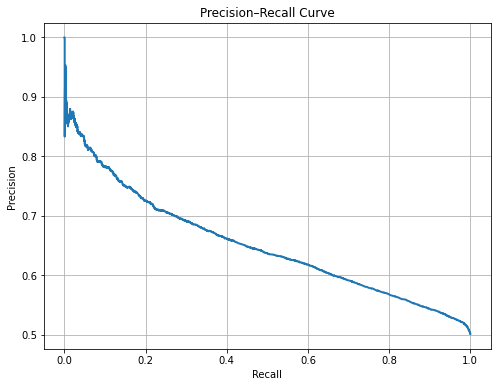

In [23]:
precision, recall, thresolds = precision_recall_curve(y_test,y_predict)
pr_auc = auc(recall,precision)
avg_precision = average_precision_score(y_test,y_predict)

print("PR-AUC:", pr_auc)
print("Average Precision Score:", avg_precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()